# Credit card fraud identification in financial payment services

## Table of Contents

1. [Introduction](#1.-Introduction)    
    1.1 [Description](#1.1-Description)  
    1.2 [Issues](#1.2-Issues)  
    1.3 [Goal](#1.3-Goal)  
2. [Data Wrangling](#2.-Wrangling)
3. [EDA](#3.-EDA)  
    3.1 [Heatmap_correlations](#3.1-Correlations)  
    3.2 [Amount_distributions](#3.2-Amount_distributions)  
    3.3 [Central_tendency](#3.3-Central_tendency)  
    3.4 [Time_series](#3.4-Time_series)
    
4. [Feature_Engineering](#4.-Feature_Engineering)
5. [Modeling](#5.-Modeling)  
    5.1 [Random_sampling_and_scaling](#5.1-Random_Sampling_and_scaling)  
    5.2 [Logistic_Regression](#5.2-Logistic_Regression)  
    5.3 [Decision_Tree](#5.3-Decision_Tree)  
    5.4 [Random_Forest_undersampled](#5.4-Random_Forest_undersampled)  
    5.5 [Random_Forest_class_weight](#5.5-Random_Forest_class_weight)  
    5.6 [Two_features](#5.6-Two_features)  
    5.7 [Gradient_Boosting](#5.7-Gradient_Boosting)  

6. [Model_evaluation](#6.-Model_evaluation)  
7. [Conclusion](#7.-Conclusion)  

## 1. Introduction

The tricky part about transactional data is that due to the private nature of transactions, there aren't any publicly available datasets. Yet transactional data is still needed for continued research into fraud detection. 

The simulated data used here is based on a simulator called PaySim which helps bridge the gap between unavailable public data and the need to continue improving fraud detection systems. PaySim utilizes aggregated real world data taken from a private dataset to generate synthetic transactional data resembling normal transactions.
This real world data is a sample of real transactions extracted from financial logs from a mobile money service implemented in an African country. More information about the data can be found here: https://www.kaggle.com/ealaxi/paysim1 

The main challenge the dataset poses to predicting fraud is the highly imbalanced distribution between positive and negative classes in 6 million rows of data.


### 1.1 Description

1. step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
2. type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
3. amount - amount of the transaction in local currency.
4. nameOrig - customer who started the transaction
5. oldbalanceOrg - initial balance before the transaction
6. newbalanceOrig - new balance after the transaction
7. nameDest - customer who is the recipient of the transaction
8. oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
9. newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
10. isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
11. isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### 1.2 Issues

This dataset does come with several issues in it. 
The first is that the data is heavily imbalanced. There are over 6 million transactions and only ~8000 are fraud. We tackle this problem in the EDA section and again in modeling with sampling.

Another issue is that the isFlaggedFraud column only has 16 positive labels and the description of the isFlagged column does not match what is seen in the data. 

Another issue is that a lot of the transaction balances between the originating account and destination account don't match the amount transacted. This is highlighted in the feature engineering section.

We attempt to address some of these issues as we work through the EDA, feature engineering, and modeling sections. 

### 1.3 Goal

The most common strategy in place for identifying potentially fraudulent transactions is to place a limit on the transaction amount; this is what the Paysim system attempts to do. This approach can work but it does have downsides and can be exploited and negatively impact the customer experience. A more intricate approach is necessary as technology continues to evolve.  

We want to be able to better predict and label fraud transactions when they occur. The current system has a fraud loss of just over $12 billion. Many customers are leaving for alternative options and potential customers are hesitant to sign up with this company. 

In our business scenario, we work for a payment processing startup which has identified a major flaw in its technology. Too many of their customers are losing money to fraudulent transactions. Specifically, the system is not catching fraud transactions and thinks a lot of them are legitimate.  

The goal is to create a more robust and intelligent classifier to be able to catch these transactions and reduce the fraud loss by $3 billion.

We do this through identifying what features correlate to existing fraud transactions and creating new features from those to help identify new ones. 

# 2. Wrangling

In [3]:
# We can start by importing necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [4]:
# This gives us a first look at the data
df = pd.read_csv('fraud_data.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# We can start by checking for any null values
# We can see that there are no null values!

df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
# A few of the columns we can look at in detail are amount, old and new origin balance, old and new destination balance 

df[['amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest']].describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


In [7]:
# We can also verify the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# 3. EDA

We can first get a look of a breakdown of our transactions by type

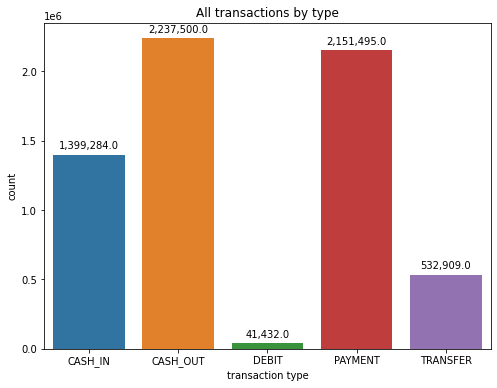

In [8]:
transactions = ['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x = transactions, y = df.groupby('type')['type'].value_counts())
plt.ylabel('count')
plt.xlabel('transaction type')
plt.title('All transactions by type')
for p in ax.patches:
    ax.annotate(format(p.get_height(), ','), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

Of all the transactions above, we can get a better look into the fraudulent ones

Text(0.5, 1.0, 'Confusion matrix for simulator results')

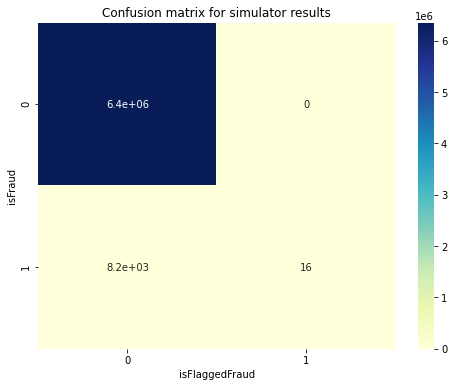

In [9]:
yt_true = list(df['isFraud'])
yt_pred = list(df['isFlaggedFraud'])
cf_matrix = metrics.confusion_matrix(yt_true, yt_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cf_matrix, annot=True, cmap='YlGnBu')
plt.xlabel("isFlaggedFraud")
plt.ylabel("isFraud")
plt.title("Confusion matrix for simulator results")

In [10]:
# Our data contains 8213 fradulent transactions
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

We see that out of over 6 million transactions, only 16 transactions were actually flagged as fraud, and over 8200 were fradulent transactions! The fraud detection system in place is not performing very well. 

Additionally, we see that the fraud transactions are only occuring in either TRANSFER or CASH_OUT types.

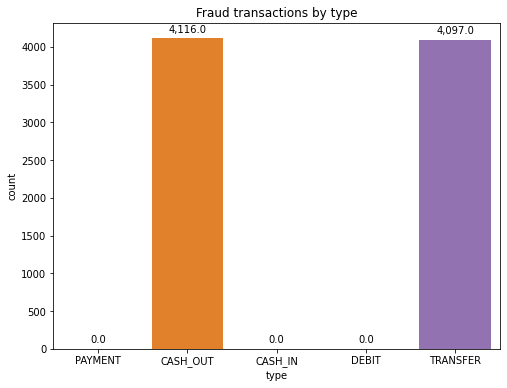

In [11]:
transaction_types = ['PAYMENT', 'CASH_OUT', 'CASH_IN', 'DEBIT', 'TRANSFER']

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x= transaction_types, y=df.groupby('type')['isFraud'].sum())
plt.title('Fraud transactions by type')
plt.xlabel('type')
plt.ylabel('count')
for p in ax.patches:
    ax.annotate(format(p.get_height(), ','), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

Conclusion:

From the above we see that fraud only occurs when the transaction is either a 'CASH OUT' or 'TRANSFER'. Since the population data is not available to resample, we can reduce our dataset to only CASH OUTS and TRANSFERS.


In [12]:
df = df[(df["type"] == "CASH_OUT") | (df["type"] == "TRANSFER")]

In [13]:
flagged = df[df['isFlaggedFraud'] == 1]

fraud = df[df['isFraud'] == 1]
nonfraud = df[df['isFraud'] == 0]

In [14]:
flagged

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


 Additionally,'isFlaggedFraud' is not related to customers who transact more than once where 'isFlagedFraud' is set.
 We obtain a list of names where there was more than 1 fraud transaction

In [15]:
names = []
multiple_flagged = []

for i in fraud['nameDest'].value_counts().index:
    if fraud['nameDest'].value_counts()[i] > 1:
        names.append(i)
    if i in flagged['nameDest']:
        multiple_flagged.append(i)

In [16]:
# We see that none of the addresses that had multiple fraud transactions were flagged as fraud
print('Addresses with multiple fraud transactions that were flagged: {}'.format(len(multiple_flagged)))

print('Number of addresses with multiple fraud transactions: {}'.format(len(names)))

Addresses with multiple fraud transactions that were flagged: 0
Number of addresses with multiple fraud transactions: 44


After looking at these, we can make the decision to drop the 'isFlaggedFraud' column, for several reasons.

    1. There are only 16 flagged transactions out of over 6 million.
    2. The column does not flag all transfers over 200,000 as fraud, and is not related to transfer type or amount. 
    3. The column is not based on multiple fraud transactions.

In [17]:
df = df.drop(labels='isFlaggedFraud', axis=1)

We see from the documentation that there are two categories of destination columns, Merchant and Customer. 
Merchant recepients were not involved in any of the fraud transactions. Additionally, millions of rows of unique labels would be taxing on our computational time. We can drop the nameorigin and namedest columns as well.

In [18]:
df = df.drop(labels=['nameOrig','nameDest'], axis=1)

In [19]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


### 3.1 Correlations

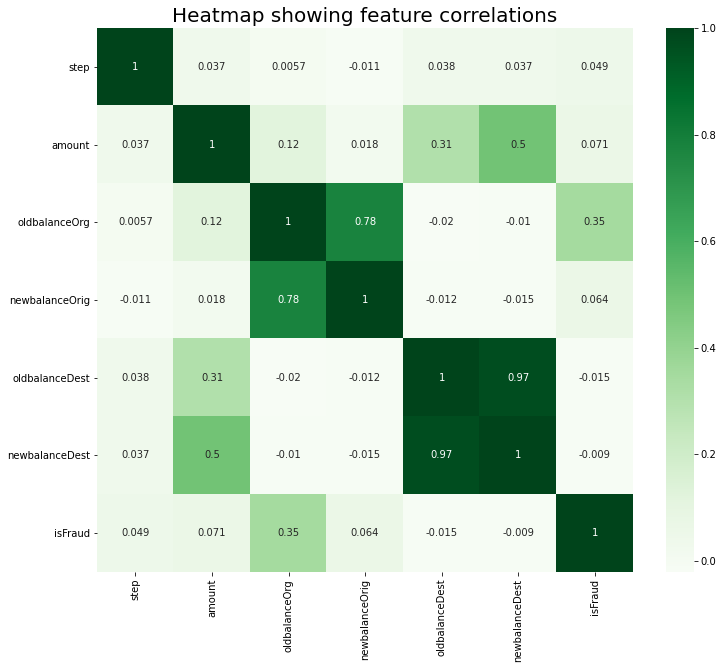

In [20]:
fig, ax = plt.subplots(figsize=(12,10))
_ = sns.heatmap(df.corr(), cmap = 'Greens', annot=True)
_ = plt.title('Heatmap showing feature correlations', fontsize=20)

### 3.2 Amount_distributions

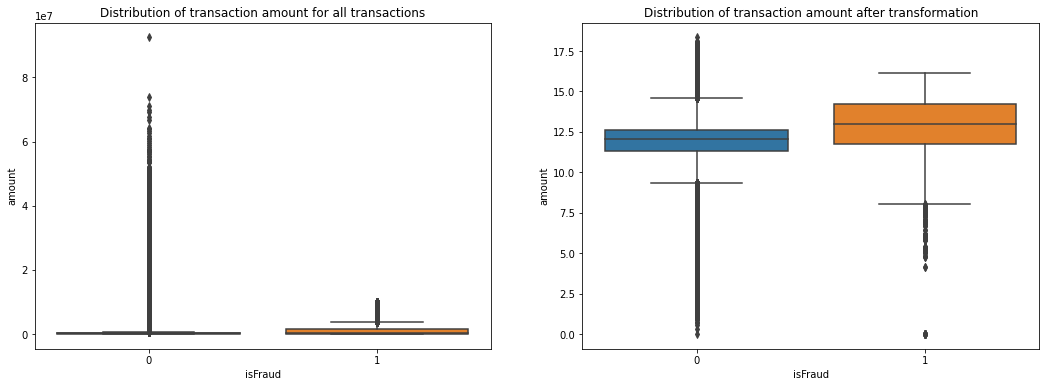

In [21]:
# We first see how the amount transacted is distributed between fraud and nonfraud transactions

# We apply a log transformation to deal with the skewed data

fig, ax = plt.subplots(1,2, figsize=(18,6))
_ = sns.boxplot(x=df.isFraud, y=df.amount, ax=ax[0])
_ = sns.boxplot(x=df.isFraud, y=np.log1p(df.amount), ax=ax[1])
_ = ax[0].title.set_text('Distribution of transaction amount for all transactions')
_ = ax[1].title.set_text('Distribution of transaction amount after transformation')

This helps us visualize how much of an effect the outliers have on the data. We can mitigate the effect of the outliers and get a better idea of the central tendency of the data with the plots below.

### 3.3 Central_tendency

Since all of our fraud transactions occured in only TRANSFER and CASH_OUT transactions, we can get a better look at those as well.

In [22]:
transfer = df[df['type'] == 'TRANSFER']
cashout = df[df['type'] == 'CASH_OUT']

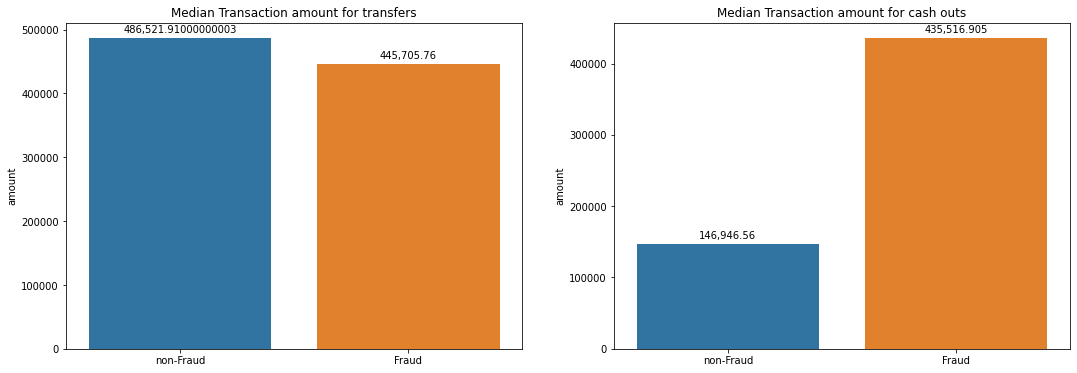

In [23]:
# Here we use median instead of mean to illustrate central tendency in order to suppress the effect of outliers

fig,ax = plt.subplots(1,2,figsize=(18,6))
ax[0].title.set_text("Median Transaction amount for transfers")
ax[1].title.set_text("Median Transaction amount for cash outs")

_ = sns.barplot(x=['non-Fraud', 'Fraud'], y=transfer.groupby('isFraud')['amount'].median(),ax=ax[0])
_ = sns.barplot(x=['non-Fraud', 'Fraud'], y=cashout.groupby('isFraud')['amount'].median(),ax=ax[1])
for i in range(2):
    for p in ax[i].patches:
        ax[i].annotate(format(p.get_height(), ','), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

The median transaction amount in CASH_OUT transactions is almost 3x higher in fraudulent transactions vs nonfraudulent ones. In transfers, the figure is much closer to even.

### 3.4 Time_series

Another aspect of fraud that we can look into is what part of the day it occurs. We can use 'step' to group the transactions into a per day basis to identify if a pattern is present.

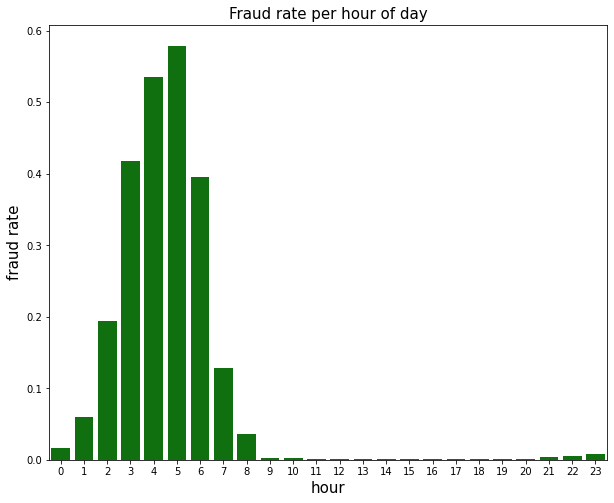

In [24]:
# Here we plot the fradulent transactions on a per hour basis

df['hour'] = df.step % 24
frauds_per_hour = pd.concat([df.groupby("hour")["isFraud"].sum(),df.groupby("hour")["isFraud"].count()],axis=1)
frauds_per_hour.columns = ['num_frauds', 'num_transactions']
frauds_per_hour['fraud_rate'] = frauds_per_hour.num_frauds / frauds_per_hour.num_transactions
_ = plt.subplots(figsize=(10,8))
_ = sns.barplot(x=frauds_per_hour.index, y= frauds_per_hour.fraud_rate, color='green')
_ = plt.title('Fraud rate per hour of day', fontsize=15)
_ = plt.xlabel('hour', fontsize=15)
_ = plt.ylabel('fraud rate', fontsize=15)

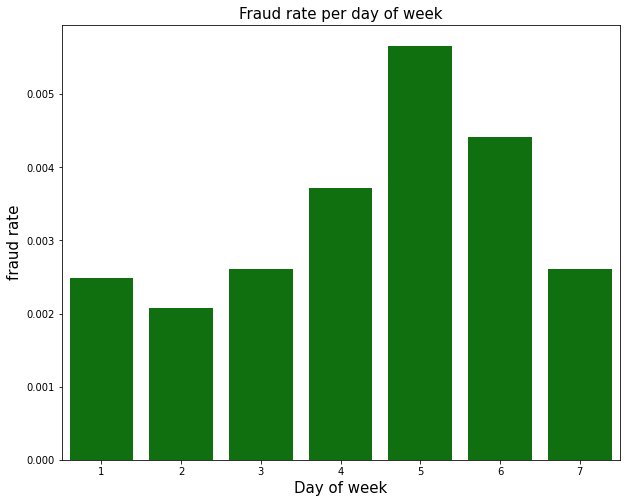

In [25]:
# We can also apply the same concept to visualize fraud rate on a weekly basis

df['dayofmonth'] = round(df.step / 24)
df['dayofweek'] = df['dayofmonth'] % 7
frauds_per_day = pd.concat([df.groupby("dayofweek")["isFraud"].sum(),df.groupby("dayofweek")["isFraud"].count()],axis=1)
frauds_per_day.columns = ['num_frauds', 'num_transactions']
frauds_per_day['fraud_rate'] = frauds_per_day.num_frauds / frauds_per_day.num_transactions
_ = plt.subplots(figsize=(10,8))
_ = sns.barplot(x=list(range(1,8)), y= frauds_per_day.fraud_rate, color='green')
_ = plt.title('Fraud rate per day of week', fontsize=15)
_ = plt.xlabel('Day of week', fontsize=15)
_ = plt.ylabel('fraud rate', fontsize=15)

Two main conclusions from our graphs here. Those are that fraud tends to occur in the early hour of the morning, before 9:00 am, and that it also tends to occur towards the end of the week.

# 4. Feature_Engineering

We have several types of features shown in our df now: Datetime features, numerical features, and categorical features. We need to do some work on all of these.

In [27]:
df1 = df.copy()

##### Datetime

The main datetime feature is 'step'. We also created 'hour', 'day', and 'dayofweek'. So this feature has already been addressed. We saw earlier how fraud transaction rates are much higher in the early morning hours and on the later days of the week.

In [28]:
# Those we have already created

df1['hour'] = df1.step % 24
df1['dayofmonth'] = round(df1.step / 24)
df1['dayofweek'] = df1['dayofweek'] % 7

In [29]:
# Lets make the hour feature a binary one for our model.

in_peak_time = []

for i in df1.hour:
    if i in list(range(9)):
        in_peak_time.append(1)
    else:
        in_peak_time.append(0)
        
df1['in_peak_time'] = in_peak_time

In [30]:
df1.in_peak_time.value_counts()

0    2728596
1      41813
Name: in_peak_time, dtype: int64

##### Categorical

The main categorical feature we will focus on here is 'type', since the others have been removed during wrangling. 
Here we can generate dummy variables for the 'type' variable.

In [31]:
df1 = pd.get_dummies(df1,columns=["type"])
df1.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour,dayofmonth,dayofweek,in_peak_time,type_CASH_OUT,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1,1,0.0,0.0,1,0,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,1,0.0,0.0,1,1,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,1,0.0,0.0,1,1,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,1,0.0,0.0,1,0,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,1,0.0,0.0,1,0,1


In [32]:
baseline_df = df1.copy()

Throughout the dataset, we can pick up on several other trends. Especially when it comes to the fraudulent transactions.

For all the fraudulent transactions:

1. We see that they all follow the same pattern: A 'TRANSFER' of a certain amount followed by a "CASH_OUT' for the same amount immediately after.
2. The 'oldbalanceDest'/'newbalanceDest' is updated (the majority of the time) only after the 'CASH_OUT', not the 'TRANSFER'

We can use this information to generate a new feature that would help our model realize this pattern.

In [33]:
# How many of the fraud transactions are coupled

coupled = 0

for i in range(len(fraud) -1):
    if (fraud.iloc[i].type == 'TRANSFER') & (fraud.iloc[i+1].type == 'CASH_OUT'):
        coupled += 2

print('coupled transactions: {}'.format(coupled))
print('Percentage of fraud transactions that are a part of a coupled transaction: {}'.format((coupled/len(fraud))*100))

coupled transactions: 8182
Percentage of fraud transactions that are a part of a coupled transaction: 99.62254961646171


In [34]:
# How many of all transactions are coupled

df1['coupled'] = 0
coupled = 0

for i in range(len(df1) -1):
    if (df1.iloc[i].type_TRANSFER == 1) & (df1.iloc[i+1].type_CASH_OUT == 1):
        coupled += 1
        df1.coupled.iloc[i] = 1
        df1.coupled.iloc[i+1] = 1
            
print('coupled transactions: {}'.format(coupled))

coupled transactions: 232838


##### Numeric

#### Balance Errors

Here we address the balance error that we saw between the originating and destination accounts. We create new numeric features based on those differences.

In [35]:
df1["errorBalanceOrg"] = df1.newbalanceOrig + df1.amount - df1.oldbalanceOrg
df1["errorBalanceDest"] = df1.oldbalanceDest + df1.amount - df1.newbalanceDest

#### Train/test split

In [36]:
# Train/test split
target = 'isFraud'

X = df1.loc[:, df1.columns != target]
y = df1.loc[:, df1.columns == target]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42, stratify = df1["isFraud"])

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1939286, 15)
(831123, 15)
(1939286, 1)
(831123, 1)


# 5. Modeling

We want to try out several different models and compare which works best. To start we can use a very simple model, a dummy classifier using our base dataframe we saved as baseline_df. This df is not scaled.

With our other df called df1, we have already scaled and performed both undersampling and oversampling. We can use this df to compare other models such as logistic regression, random forest, and Gradient boosting.

### Simple classifier

In [90]:
# We can start with a simple classifier using our unscaled dataset: baseline_df

X1 = baseline_df.drop('isFraud', axis=1)
y1 = baseline_df.isFraud

X1train, X1test, y1train, y1test = train_test_split(X1,y1, test_size = 0.3, random_state = 42, stratify = df1["isFraud"])

In [91]:
dc = DummyClassifier(random_state=42)
startfit1 = timer()
dc.fit(X1train, y1train)
endfit1 = timer()
starttest1 = timer()
ypred = dc.predict(X1test)
endtest1 = timer()
print(classification_report(ypred, y1test))
print(confusion_matrix(ypred, y1test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828638
           1       0.00      0.00      0.00      2485

    accuracy                           0.99    831123
   macro avg       0.50      0.50      0.50    831123
weighted avg       0.99      0.99      0.99    831123

[[826178   2460]
 [  2481      4]]


### 5.1 Random_Sampling_and_scaling

We introduce scaling and undersampling into our models. 

Generally with skewed datasets such as the fraud dataset we are working with we run into the issue of imbalanced data. This imbalanced data influences the performance of a ML model. 
Generally with fraud data this is the case, it would be worrying if the fraud and non fraud data was evenly distributed! 
We need to use methods such as undersampling or oversampling so that our model is't influenced by the highly skewed data.

Undersampling deletes samples from the majority class.
Oversampling duplicates samples from the minority class. 

Here we use random undersampling since we have a large amount of the majority data. Random sampling is a simple technique that assumes nothing of the data. There are other methods for undersampling and oversampling that may be used if random sampling is deemed too simple. 

#### Scaling

Performing feature scaling is really dependent on which ML model you use. In some cases scaling the features can help model performance, in other cases it does not. 


Gradient descent based algorithms require features to be scaled, and this is why it is used here with logistic regression and with the gradient boosting model. On the other hand, tree based algorithms are not affected by scaling, this is why it is not used in the random forest model. 

#### Metrics for measuring successful models

Selecting the correct metric to use for our model is very important.
Since our data is highly imbalanced, accuracy would not be a good metric to evaluate our models. 
Additionally, since we are dealing with a binary classification (either fraud or non-fraud) instead of probabilities, then we can rule out using metrics like AUC curve or PR score, which are more useful for probabilities.

With imbalanced data, we should focus on using metrics such as precision, recall, or F1 score.

The metric we use is dependent on the business problem. In our case, the impact of mislabeling a fraud transaction as nonFraud is much more damaging than having a nonFraud labeled as Fraud. Thus, using recall as a metric, (defined as TP / TP + FN) is what we will use. A secondary option would be to use F1 as a metric, which acts as a harmoic mean between precision and recall. This metric may be a better option to use in another business context.

### 5.2 Logistic_Regression

In [92]:
# We can scale our numeric columns

numeric_features = ['amount', 'oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest', 'errorBalanceOrg', 'errorBalanceDest']
numeric_transformer = Pipeline(steps=[(('scaler', StandardScaler()))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

In [93]:
lr = Pipeline(steps=[('preprocessor', preprocessor),
                     ('usampler',RandomUnderSampler(random_state=42)),
                     ('clf',LogisticRegression(random_state=42, class_weight = 'balanced'))])

parameters = {'usampler__sampling_strategy': [0.5, 0.6,0.7,0.75,0.8,0.85]}

lr_pipeline = GridSearchCV(lr,parameters,scoring='f1')

# Once optimal parameters are found, we can time the model itself

startfit2 = timer()
lr_pipeline.fit(X_train, y_train)
endfit2 = timer()
starttest2 = timer()
y_predlr = lr_pipeline.predict(X_test)
endtest2 = timer()
print(lr_pipeline.best_params_)
print(lr_pipeline.best_score_)


{'usampler__sampling_strategy': 0.8}
0.07098028188485558


In [94]:
print(classification_report(y_predlr, y_test))
print(confusion_matrix(y_predlr, y_test))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97    773454
           1       0.86      0.04      0.07     57669

    accuracy                           0.93    831123
   macro avg       0.90      0.52      0.52    831123
weighted avg       0.93      0.93      0.90    831123

[[773104    350]
 [ 55555   2114]]


### 5.3 Decision_Tree

In [172]:
dt = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('dt',DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

parameters = {
    'sampler__sampling_strategy': [0.5,0.6,0.7,0.75,0.8,0.85],
    'dt__max_depth': [3,5,10]
  }


grid_pipeline1 = GridSearchCV(dt,parameters,scoring='f1',cv=5)

startfit3 = timer()
grid_pipeline1.fit(X_train, y_train)
endfit3 = timer()
starttest3 = timer()
y_pred22 = grid_pipeline1.predict(X_test)
endtest3 = timer()
print(grid_pipeline1.best_params_)
print(grid_pipeline1.best_score_)


{'dt__max_depth': 3, 'sampler__sampling_strategy': 0.5}
0.9773954676002067


In [173]:
print(classification_report(y_pred22, y_test))
print(confusion_matrix(y_pred22, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828028
           1       1.00      0.79      0.88      3095

    accuracy                           1.00    831123
   macro avg       1.00      0.90      0.94    831123
weighted avg       1.00      1.00      1.00    831123

[[828018     10]
 [   641   2454]]


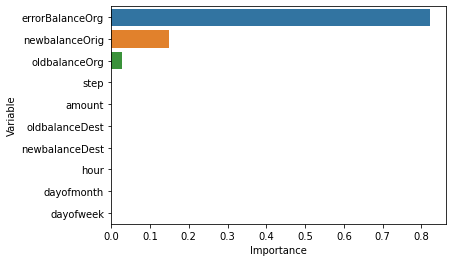

In [174]:
imp = pd.DataFrame({"Variable":list(X_train.columns),"Importance":grid_pipeline1.best_estimator_['dt'].feature_importances_})
imp = imp.sort_values("Importance",ascending=False)
sns.barplot(x=imp.Importance.head(10),y=imp.Variable.head(10))

### 5.4 Random_Forest_undersampled

In [98]:
rf = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('rf',RandomForestClassifier(random_state=42))
])

parameters = {
    'sampler__sampling_strategy': [0.5,0.6,0.7,0.75,0.8, 0.85,'majority'],
    'rf__n_estimators':[1,10,100,200]}


grid_pipeline1 = GridSearchCV(rf,parameters, scoring='f1')
startfit4 = timer()
grid_pipeline1.fit(X_train, y_train)
endfit4 = timer()
starttest = timer()
y_predrf = grid_pipeline1.predict(X_test)
endtest4 = timer()
print(grid_pipeline1.best_params_)
print(grid_pipeline1.best_score_)


{'rf__n_estimators': 100, 'sampler__sampling_strategy': 0.6}
0.9637537371488101


In [99]:
print(classification_report(y_predrf, y_test))
print(confusion_matrix(y_predrf, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828484
           1       1.00      0.93      0.96      2639

    accuracy                           1.00    831123
   macro avg       1.00      0.97      0.98    831123
weighted avg       1.00      1.00      1.00    831123

[[828475      9]
 [   184   2455]]


Text(33.0, 0.5, 'actual')

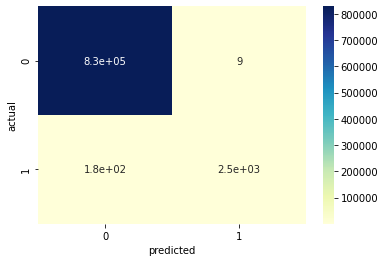

In [100]:
cf_matrix = metrics.confusion_matrix(y_predrf, y_test)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True, cmap='YlGnBu')
plt.xlabel("predicted")
plt.ylabel("actual")

### 5.5 Random_Forest_class_weight

In [101]:
rf = Pipeline([('rf',RandomForestClassifier(random_state=42, class_weight='balanced'))])

parameters = {
    'rf__n_estimators':[10,100],
    'rf__max_depth': [10]}

grid_pipeline3 = GridSearchCV(rf,parameters, scoring='recall')
startfit5 = timer()
grid_pipeline3.fit(X_train, y_train)
endfit5 = timer()
starttest5 = timer()
y_predrf1 = grid_pipeline3.predict(X_test)
endtest5 = timer()
print(grid_pipeline3.best_params_)
print(grid_pipeline3.best_score_)


{'rf__max_depth': 10, 'rf__n_estimators': 100}
0.9956515684716388


In [102]:
print(classification_report(y_predrf1, y_test))
print(confusion_matrix(y_predrf1, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828666
           1       1.00      1.00      1.00      2457

    accuracy                           1.00    831123
   macro avg       1.00      1.00      1.00    831123
weighted avg       1.00      1.00      1.00    831123

[[828657      9]
 [     2   2455]]


Text(33.0, 0.5, 'actual')

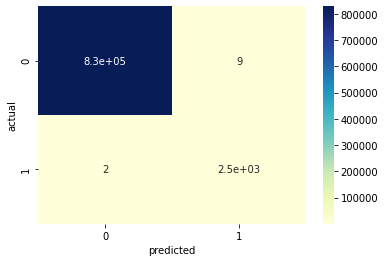

In [103]:
cf_matrix = metrics.confusion_matrix(y_predrf1, y_test)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True, cmap='YlGnBu')
plt.xlabel("predicted")
plt.ylabel("actual")

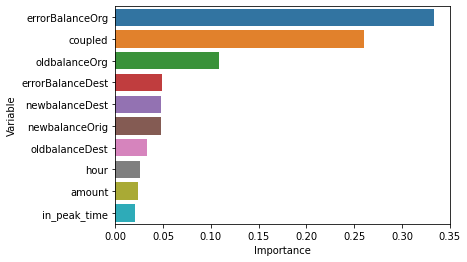

In [104]:
imp = pd.DataFrame({"Variable":list(X_train.columns),"Importance":grid_pipeline3.best_estimator_['rf'].feature_importances_})
imp = imp.sort_values("Importance",ascending=False)
sns.barplot(x=imp.Importance.head(10),y=imp.Variable.head(10))

### 5.6 Two_features

In [105]:
# Here we see how the data with the features performs on the test set only, we use our best model (RF without undersampling)

In [106]:
cols = ['coupled', 'errorBalanceOrg']
X2 = df1[cols]
y2 = df1.loc[:, df1.columns == target]


X2train, X2test, y2train, y2test = train_test_split(X2,y2, test_size = 0.3, random_state = 42, stratify = df1["isFraud"])


In [107]:
rf = Pipeline([('rf',RandomForestClassifier(random_state=42, class_weight='balanced'))])

parameters = {
    'rf__n_estimators':[10],
    'rf__max_depth': [10]}

grid_pipeline5 = GridSearchCV(rf,parameters, scoring='f1')
startfit6 = timer()
grid_pipeline5.fit(X2train, y2train)
endfit6 = timer()
starttest6 = timer()
y_predrf12 = grid_pipeline5.predict(X2test)
endtest6 = timer()
print(grid_pipeline5.best_params_)
print(grid_pipeline5.best_score_)


{'rf__max_depth': 10, 'rf__n_estimators': 10}
0.23391376439130623


In [108]:
print(classification_report(y_predrf12, y2test))
print(confusion_matrix(y_predrf12, y2test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    812747
           1       0.99      0.13      0.24     18376

    accuracy                           0.98    831123
   macro avg       0.99      0.57      0.61    831123
weighted avg       0.98      0.98      0.97    831123

[[812733     14]
 [ 15926   2450]]


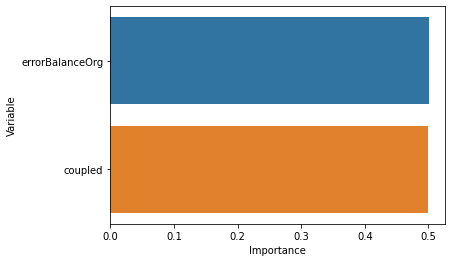

In [109]:
imp = pd.DataFrame({"Variable":list(X2train.columns),"Importance":grid_pipeline5.best_estimator_['rf'].feature_importances_})
imp = imp.sort_values("Importance",ascending=False)
sns.barplot(x=imp.Importance.head(10),y=imp.Variable.head(10))

### 5.7 Gradient_Boosting

In [110]:
xgb = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('xgb',GradientBoostingClassifier(random_state=42, max_features='sqrt'))
    ])

parameters = {
    'sampler__sampling_strategy': [0.5,0.6, 0.7, 0.75, 0.8, 0.85],
    'xgb__n_estimators': [1, 100, 500]
}

grid_pipeline = GridSearchCV(xgb,parameters, scoring='f1')
startfit7 = timer()
grid_pipeline.fit(X_train, y_train)
endfit7 = timer()
starttest7 = timer()
y_pred_gb = grid_pipeline.predict(X_test)
endtest7 = timer()
print(grid_pipeline.best_params_)
print(grid_pipeline.best_score_)


{'sampler__sampling_strategy': 0.5, 'xgb__n_estimators': 100}
0.9626662759689477


In [111]:
print(classification_report(y_pred_gb, y_test))
print(confusion_matrix(y_pred_gb, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828465
           1       1.00      0.92      0.96      2658

    accuracy                           1.00    831123
   macro avg       1.00      0.96      0.98    831123
weighted avg       1.00      1.00      1.00    831123

[[828457      8]
 [   202   2456]]


Text(33.0, 0.5, 'actual')

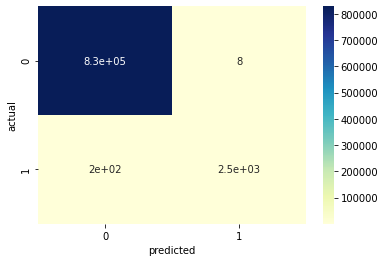

In [112]:
cf_matrix = metrics.confusion_matrix(y_pred_gb, y_test)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True, cmap='YlGnBu')
plt.xlabel("predicted")
plt.ylabel("actual")

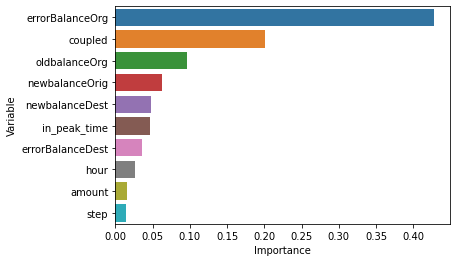

In [113]:
imp = pd.DataFrame({"Variable":list(X_train.columns),"Importance":grid_pipeline.best_estimator_['xgb'].feature_importances_})
imp = imp.sort_values("Importance",ascending=False)
sns.barplot(x=imp.Importance.head(10),y=imp.Variable.head(10))

# 6. Model_evaluation

In classification problems such as this, accuracy is not the best metric to use in order to evaluate model performance. As mentioned before, in our business problem, focusing on recall score would be a much better metric to use.


In [114]:
from sklearn.metrics import recall_score

#### Winning model

In [116]:
### Model performance comparisons
model_type = ['Dummy_classifier', 'Logistic_regression', 'Decision_Tree', 'RF_us', 'RF_no_us', 'RF_2_feat', 'Gradient_Boosting']
recall_scores = [recall_score(ypred, y1test), recall_score(y_predlr, y_test), recall_score(y_pred22, y_test), 
                recall_score(y_predrf, y_test), recall_score(y_predrf1, y_test), recall_score(y_predrf12, y2test), recall_score(y_pred_gb, y_test)]
fit_times = [endfit1 - startfit1, endfit2 - startfit2, endfit3 - startfit3, endfit4 - startfit4, endfit5 - startfit5,
            endfit6 - startfit6, endfit7 - startfit7]
test_times = [endtest1 - starttest1,endtest2 - starttest2,endtest3 - starttest3,endtest4 - starttest,endtest5 - starttest5,
             endtest6 - starttest6,endtest7 - starttest7]

In [159]:
c = pd.DataFrame(fit_times, index= model_type, columns = ['fit_time'])
t = pd.DataFrame(test_times, index= model_type, columns = ['test_time'])
x = pd.DataFrame(recall_scores, index = model_type, columns= ['Recall_score'])
x.join(c).join(t)

,Recall_score,fit_time,test_time
Dummy_classifier,0.001610,0.077906,0.027585
Logistic_regression,0.036657,30.685976,0.073037
Decision_Tree,0.792892,67.197832,0.089767
RF_us,0.930277,416.678223,5.023380
RF_no_us,0.999186,1509.206884,5.154136
RF_2_feat,0.133326,120.008560,0.560250
Gradient_Boosting,0.924003,236.461163,1.014228


We see that the most accurate algorithm is by far the most computationally intensive. While the fit times have a lot to do with the hyperparameter tuning and can be changed, the test times show the performance of the model using the best parameters. 

The decision to make depends on what we value more, computation time or accuracy.
If accuracy is what we look for then random forest would be the choice. If its a combination of accuracy and speed, then gradient boosting would be the choice model.

In our business context we are focusing on minimizing the number of fraud transactions that are misclassified as non-fraud. Thus, as mentioned earlier, we focus on recall score. In another context, f1 may be a good score to use to optimize the misclassified transactions overall, including both precision and recall.

For instance, if we wanted to optimize the number of non-Frauds misclassified as fraud (precision), several models would be useful here. The decision tree, random forest, and gradient boosted model all have 1.0 precision values.

In our case however, for recall optimization, we see that the random forest model outperforms the rest, only mislabeling 2 fraud transactions as non fraud. We can take a look at the confusion matrix of that model here:

It is possible that the class weight metric of the random forest combats the imbalance data issue and may exmplain why the random forest without undersampling performs better than the other models.

Text(33.0, 0.5, 'actual')

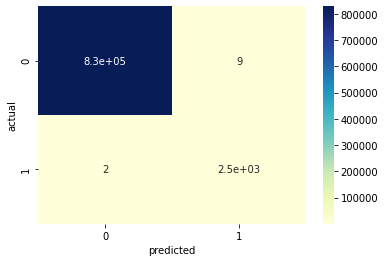

In [66]:
cf_matrix = metrics.confusion_matrix(y_predrf1, y_test)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True, cmap='YlGnBu')
plt.xlabel("predicted")
plt.ylabel("actual")

#  <a name="7.-Conclusion"></a>7. Conclusion

Models can always be optimized. The tradeoff is that tuning parameters using CV algorithms such as GridSearchCV comes with the heavy cost of computation time. There may be parameters that produce much better results than our winning model, however, the decision we make for the business is that those steps need not be taken. The winning model is accurate enough and satisfies our business goals. 

Our winning model classifies 2455 out of 2457 fraud correctly from our test set and 828657 out of 828666 nonFrauds correctly. Implementing this model into our system would drastically improve fraud detection rate and help retain existing customers and incentivize new customers to join. 
Had our winning model been in place, it would have detected 8206 of the 8213 frauds and prevented the loss of over $3.6 billion.